In [1]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [2]:
from google.colab import drive

drive.mount('./gdrive', force_remount=True)
%cd './gdrive/My Drive/Colab Notebooks/cubricks'

Mounted at ./gdrive
/content/gdrive/My Drive/Colab Notebooks/cubricks


In [3]:
!pip -q install pandas-profiling imbalanced-learn tensorflow-gpu --upgrade

     |████████████████████████████████| 266kB 2.8MB/s 
     |████████████████████████████████| 174kB 8.3MB/s 
     |████████████████████████████████| 320.4MB 34kB/s 
     |████████████████████████████████| 71kB 6.2MB/s 
     |████████████████████████████████| 604kB 38.4MB/s 
     |████████████████████████████████| 3.1MB 28.4MB/s 
     |████████████████████████████████| 71kB 4.9MB/s 
     |████████████████████████████████| 71kB 7.2MB/s 
     |████████████████████████████████| 6.8MB 29.8MB/s 
     |████████████████████████████████| 296kB 38.1MB/s 


In [4]:
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

seed = 42

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [22]:
def plot_countplot(df, cols, title=None, rotation=0):
    for col in cols:
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 2))
        g = sns.countplot(np.squeeze(df[col] if isinstance(col, str) else df[:,col]), ax=ax)
        g.set_xticklabels(labels=g.get_xticklabels(), rotation=rotation)
        g.set_title(title)

def plot_confuncion_matrix(y_test, predict, title='Confusion Matrix', report=True):
    if report: print(classification_report(y_test, y_predict))
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))
    g = sns.heatmap(confusion_matrix(y_test, predict), fmt='d', square=True, annot=True, cmap='Blues', ax=ax)
    g.set_title(title)

def plot_feature_importance(features, importances):
    features = np.array(features)
    indices = np.argsort(importances)[::-1]
    print(f'Feature ranking:')

    for f in range(len(features)):
        print(f'{importances[indices[f]]}\t{features[indices[f]]}')

    plt.figure(figsize=(10, 8))
    plt.barh(range(len(features)), importances[indices])
    plt.yticks(range(len(features)), features[indices])
    plt.title('Feature Importance')
    plt.gca().invert_yaxis()
    plt.show()

def setup_buckets(df, col, bins, sufix='Bucket'):
    bins = [-np.inf] + bins + [np.inf]
    labels = [f'{bins[i]} to {bins[i+1]-1}' for i in range(len(bins[:-1]))]
    df[col + sufix + 'Category'] = pd.cut(df[col], bins=bins, labels=labels, right=False, include_lowest=True)
    df[[col + sufix]] = df[[col + sufix + 'Category']].apply(lambda x: pd.Categorical(x, ordered=True).codes)
    return df

def split_data_month_window(df, col, date, month_window):
    date_0 = pd.to_datetime(date)
    date_1 = date_0 - pd.DateOffset(months=month_window)
    date_2 = date_0 + pd.DateOffset(months=1)

    train = df[(df[col] >= date_1) & (df[col] < date_0)]
    test = df[(df[col] >= date_0) & (df[col] < date_2)]

    train.reset_index(drop=True, inplace=True)
    test.reset_index(drop=True, inplace=True)
    return train, test

def prepare_data(train, test, y_column, x_column, random_state=None):
    randomize = np.arange(train.shape[0])
    np.random.seed(random_state)
    np.random.shuffle(randomize)

    x_train, y_train = train[x_column].values[randomize], train[y_column].values[randomize]
    x_test, y_test = test[x_column].values, test[y_column].values

    x_train, x_test = np.vectorize(np.log)(x_train + 1), np.vectorize(np.log)(x_test + 1)

    qt = RobustScaler(quantile_range=(5, 95))
    qt.fit(np.concatenate((x_train, x_test)), np.concatenate((y_train, y_test)))
    x_train, x_test = qt.transform(x_train), qt.transform(x_test)

    return x_train, y_train, x_test, y_test

def classifier_predict(clf, x_test, threshold=0.5, network=False):
    y_predict = clf.predict(x_test) if network else clf.predict_proba(x_test)
    return (y_predict[:,1] >= threshold).astype('int')

In [23]:
### Read dataset ###
df = pd.read_csv('InvoicedDocuments_v5.csv', sep=';', na_values=['N/I'], parse_dates=['DocumentDate', 'DueDate', 'ClearingDate'])

### First filters ###
df.dropna(subset=['ClearingDate', 'PaymentTerms'], inplace=True)
df = df[(df['DueDate'] > df['DocumentDate']) & (df['ClearingDate'] > df['DocumentDate'])]
df = df[df['DocumentDate'] >= '2018-03-01']

df.sort_values(by=['DocumentDate'], ascending=True, ignore_index=True, inplace=True)
df.reset_index(drop=True, inplace=True)

### Fix numerical columns ###
for amount, count in zip(['InvoicedAmount', 'PaidAmount', 'PaidPastAmount', 'OpenAmount', 'PastDueAmount'],
                         ['InvoicedDocuments', 'PaidDocuments', 'PaidPastDocuments', 'OpenDocuments', 'PastDueDocuments']):
    df[amount] = df[amount] / df[count]
    df[[amount, count]] = df[[amount, count]].fillna(0)

avg_cols = ['AvgDSOPastDueDocuments', 'AvgPastDueDays']
df[avg_cols] = df[avg_cols].fillna(0)

### Extract date information ###
date_int = lambda x: x.astype('timedelta64[D]').astype(int)

for col in ['DocumentDate', 'DueDate']:
    df[col + 'DayOfYear'] = pd.DatetimeIndex(df[col]).dayofyear
    df[col + 'Month'] = pd.DatetimeIndex(df[col]).month
    df[col + 'Day'] = pd.DatetimeIndex(df[col]).day
    df[col + 'WeekDay'] = pd.DatetimeIndex(df[col]).weekday

### Days to DueDate ###
df['DocumentDateToDueDate'] = date_int(df['DueDate'] - df['DocumentDate'])
### Days to MonthEnd ###
df['DocumentDateToMonthEnd'] = date_int((df['DocumentDate'] + pd.offsets.MonthEnd(1)) - df['DocumentDate'])
df['DueDateToMonthEnd'] = date_int((df['DueDate'] + pd.offsets.MonthEnd(1)) - df['DueDate'])
### Days to ClearingDate ###
df['DueDateToClearingDate'] = date_int(df['ClearingDate'] - df['DueDate'])
df['DocumentDateToClearingDate'] = date_int(df['ClearingDate'] - df['DocumentDate'])

### Categorical columns ###
category_cols = ['CompanyKey', 'CustomerKey', 'CorporateDivision', 'CustomerRegion', 'PaymentTerms']
df['CustomerRegion'].fillna(df['CustomerRegion'].value_counts().idxmax(), inplace=True)
df[category_cols] = df[category_cols].apply(lambda x: pd.Categorical(x, ordered=False).codes)

df.head()

,CompanyKey,CorporateDivision,CustomerKey,CustomerRegion,DocumentDate,DueDate,ClearingDate,PaymentTerms,DocumentNumber,DocumentAmount,InvoicedDocuments,InvoicedAmount,PaidDocuments,PaidAmount,PaidPastDocuments,PaidPastAmount,OpenDocuments,OpenAmount,PastDueDocuments,PastDueAmount,AvgDSOPastDueDocuments,AvgPastDueDays,DocumentDateDayOfYear,DocumentDateMonth,DocumentDateDay,DocumentDateWeekDay,DueDateDayOfYear,DueDateMonth,DueDateDay,DueDateWeekDay,DocumentDateToDueDate,DocumentDateToMonthEnd,DueDateToMonthEnd,DueDateToClearingDate,DocumentDateToClearingDate
0,8,10,1608,92,2018-03-01,2018-03-13,2018-03-08,74,926703470,14458.55,421.0,44818.398361,373.0,45298.287507,7.0,53243.340000,48.0,41089.259792,8.0,48173.293750,15.714286,0.061758,60,3,1,3,72,3,13,1,12,30,18,-5,7
1,6,16,1087,108,2018-03-01,2018-03-23,2018-04-10,121,926710279,166.57,3374.0,471.716989,1988.0,494.329723,196.0,394.457806,1386.0,439.282561,867.0,414.684591,25.765306,0.224363,60,3,1,3,82,3,23,4,22,30,8,18,40
2,6,16,1087,108,2018-03-01,2018-03-23,2018-04-10,121,926710680,303.06,3374.0,471.716989,1988.0,494.329723,196.0,394.457806,1386.0,439.282561,867.0,414.684591,25.765306,0.224363,60,3,1,3,82,3,23,4,22,30,8,18,40
3,6,16,1087,108,2018-03-01,2018-03-23,2018-04-10,121,926711099,409.80,3374.0,471.716989,1988.0,494.329723,196.0,394.457806,1386.0,439.282561,867.0,414.684591,25.765306,0.224363,60,3,1,3,82,3,23,4,22,30,8,18,40
4,6,16,1087,108,2018-03-01,2018-03-23,2018-04-10,121,926705800,393.52,3374.0,471.716989,1988.0,494.329723,196.0,394.457806,1386.0,439.282561,867.0,414.684591,25.765306,0.224363,60,3,1,3,82,3,23,4,22,30,8,18,40


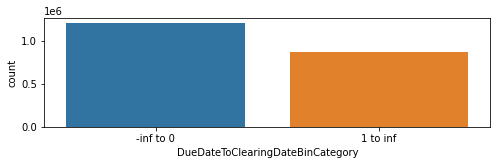

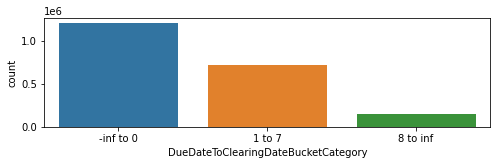

In [24]:
df = setup_buckets(df, col='DueDateToClearingDate', bins=[1], sufix='Bin')
df = setup_buckets(df, col='DueDateToClearingDate', bins=[1, 8], sufix='Bucket')
# df = setup_buckets(df, col='DueDateToClearingDate', bins=[-1, 1], sufix='Bin')
# df = setup_buckets(df, col='DueDateToClearingDate', bins=[-7, -4, -3, -2, -1, 0, 1, 2, 3, 5, 8], sufix='Bucket')

plot_countplot(df, cols=['DueDateToClearingDateBinCategory', 'DueDateToClearingDateBucketCategory'])

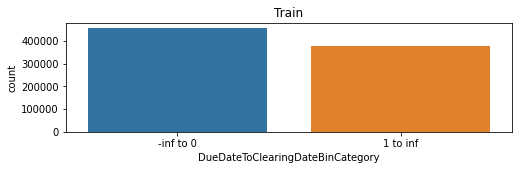

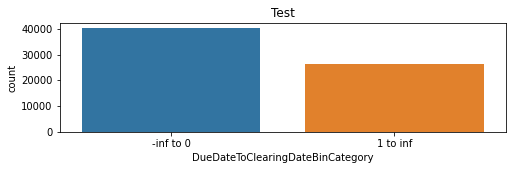

In [31]:
y_column = np.array(['DueDateToClearingDateBin'])
x_column = np.array([
                    'AvgPastDueDays',
                    'AvgDSOPastDueDocuments',
                    # 'PaidDocuments',
                    # 'PaidAmount',
                    # 'InvoicedDocuments',
                    # 'InvoicedAmount',
                    # 'OpenDocuments',
                    # 'OpenAmount',
                    # 'PaidPastDocuments',
                    'PastDueAmount',
                    'PaidPastAmount',
                    # 'PastDueDocuments',
                    'DocumentAmount',
                    'DocumentDateToDueDate',
                        'CompanyKey',
                        'PaymentTerms',
                        'CorporateDivision',
                        'CustomerKey',
                        'CustomerRegion',
                    'DocumentDateDay',
                    'DocumentDateWeekDay',
                    'DocumentDateDayOfYear',
                    # 'DocumentDateToMonthEnd',
                    # 'DocumentDateMonth',
                    'DueDateDay',
                    'DueDateWeekDay',
                    'DueDateDayOfYear',
                    # 'DueDateToMonthEnd',
                    # 'DueDateMonth',
                    ])


train, test = split_data_month_window(df, col='DueDate', date='2020-08-01', month_window=12)
x_train, y_train, x_test, y_test = prepare_data(train, test, y_column, x_column, random_state=seed)

plot_countplot(train, cols=['DueDateToClearingDateBinCategory'], title='Train')
plot_countplot(test, cols=['DueDateToClearingDateBinCategory'], title='Test')

              precision    recall  f1-score   support

           0       0.87      0.88      0.87     40238
           1       0.81      0.79      0.80     26189

    accuracy                           0.85     66427
   macro avg       0.84      0.84      0.84     66427
weighted avg       0.85      0.85      0.85     66427



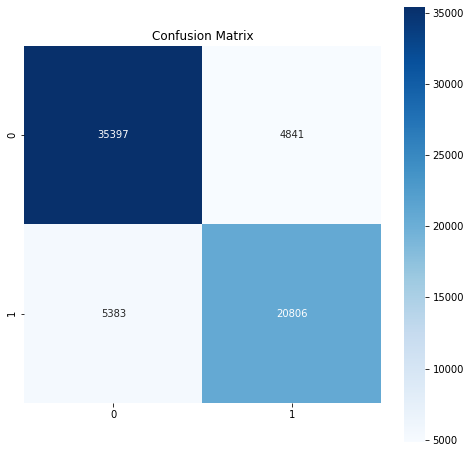

In [32]:
clf = RandomForestClassifier(n_estimators=75, criterion='entropy', random_state=seed, n_jobs=-1)
clf.fit(x_train, np.squeeze(y_train))

y_predict = classifier_predict(clf, x_test, threshold=0.5)
plot_confuncion_matrix(test[y_column].values, y_predict)

              precision    recall  f1-score   support

           0       0.63      1.00      0.77     40238
           1       1.00      0.08      0.15     26189

    accuracy                           0.64     66427
   macro avg       0.81      0.54      0.46     66427
weighted avg       0.77      0.64      0.52     66427



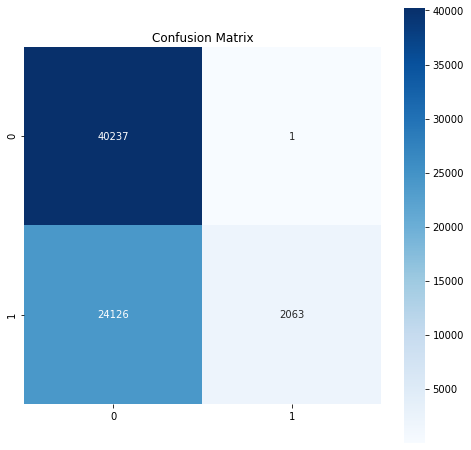

In [33]:
y_predict = classifier_predict(clf, x_test, threshold=0.9999)
plot_confuncion_matrix(test[y_column].values, y_predict)

Feature ranking:
0.1555293828828297	DocumentAmount
0.1423579417262012	AvgPastDueDays
0.07359618595299287	PastDueAmount
0.07079430565987081	AvgDSOPastDueDocuments
0.06803580392292485	PaidPastAmount
0.059401644650097785	CompanyKey
0.05478344835518733	CustomerKey
0.04779915641576962	DueDateWeekDay
0.04429335807280765	PaymentTerms
0.042487618865314165	DueDateDayOfYear
0.04132699581890706	DocumentDateDayOfYear
0.037241969775493704	DocumentDateToDueDate
0.036209160350634484	CorporateDivision
0.035065217288074234	DueDateDay
0.03147070128269864	CustomerRegion
0.030799597860593206	DocumentDateDay
0.028807511119602704	DocumentDateWeekDay


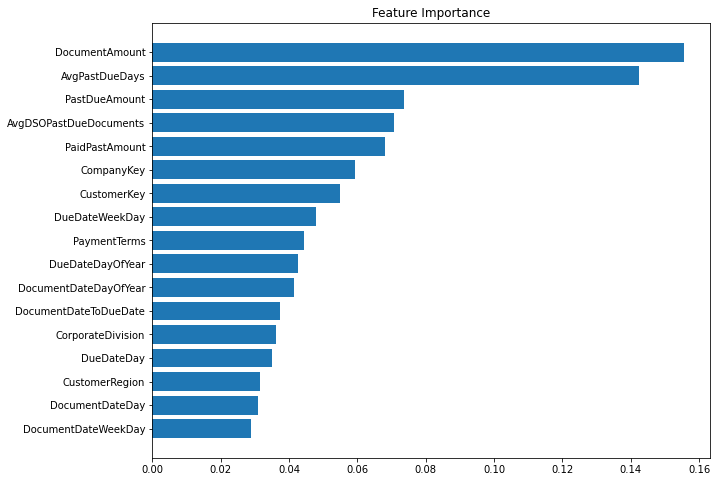

In [34]:
plot_feature_importance(x_column, clf.feature_importances_)

In [ ]:
print(test[test['DueDateToClearingDateBin'] == 1]['DocumentAmount'].max())
print(test[y_predict == 1]['DocumentAmount'].max(), '\n')

print(test[test['DueDateToClearingDateBin'] == 1]['DocumentAmount'].describe(), '\n')
print(test[y_predict == 1]['DocumentAmount'].describe())